# Visualization

This notebook contains the code to create three visualizations of the scraped data. 

In [1]:
# import libraries
import h5py
import pandas as pd
import numpy as np
import sys
import datetime as dt
import dateutil as du
import matplotlib.pyplot as plt

# show all numpy contents
np.set_printoptions(threshold=sys.maxsize)
# suppress scientific notation
np.set_printoptions(suppress=True)

## Global Functions

The following global functions will be used throughout the script. 

In [2]:
def get_date(date_str):  
    """ get the date from a timestamp converted to a string
    
    :param date_str: a datetime timestamp converted to string (numpy bytes)
    :return: the date (e.g., '2023-03-23') of the timestamp (string)
    """
    dt_format = du.parser.parse(date_str)
    return str(dt_format.date())


def get_index_day(dates, date): 
    """ get the index of the date from the dates list
    
    :param dates: a dates list in which the date is searched for (list)
    :param date: the date string to search for (string)
    :return: the index of the date (int)
    """
    return dates.index(date)


def get_next_day(date):
    """ get the date of the day following the passed date
    
    :param date: the date for which to determine the date of the next day (string)
    :return: the date of the day following the passed date (string)
    """
    dt_format = dt.datetime.strptime(date, '%Y-%m-%d')
    tomorrow = dt_format + dt.timedelta(days=1)
    return tomorrow.strftime('%Y-%m-%d')


def get_indexes_day(dates, date):  
    """ identify the indexes of the date and the date following the date in the list of dates
    
    :param dates: the list of dates (string)
    :param date: the date for which the to identify the indexes (string)
    :return: a list of the indexes (list of ints)
    """
    index_date = get_index_day(dates, date)  # get the index of the date
    next_date = get_next_day(date)  # get the date of the next day
    # check whether the next day exists in the list of dates 
    try:
        index_next = get_index_day(dates, next_date)
    except ValueError:  # if the next day does not exist, a ValueError is issued
        index_next = None
    return [index_date, index_next]

## Plotting the Precipitation Values together with the Wait Times for Orbitron 

In [3]:
# open the HDF5 file containing the wait times and weather forecasts for Disneyland
f = h5py.File('disneyland.hdf5', 'r') 

In [4]:
# identify the rainiest day

# retrieve the precipitation data
today = f['weather/today']
prec_st = today.dims[0]['storage_time']
prec = today['precipitation'][...] 

# find the maximum precipitation
most_rain = np.max(prec)

# identify when the maximum precipitation occurred
index = np.where(prec == most_rain) 

if len(index) > 1:  # if the maximum precipitation happened more than once
    day_index = int(index[0][0])  # return the index of the first dimension for the first time when the maximum precipitation occurred
else:  # if the maximum precipitation only happened once
    day_index = int(index[0])  # return the index of the first dimension
    
rainiest_day = prec_st[day_index]  # make use of partial I/O to read only the necessary data

In [5]:
# get the wait times for orbitron for that day

# retrieve the respective dataset and the storage time
orb = f['rides/orbitron/q_times']
orb_st = orb.dims[0]['storage_time'][...]

# extract the dates from the save times
orb_st_date = list(map(get_date, orb_st))

# get the indexes of the rainiest day
rainiest_date = get_date(rainiest_day)
indexes = get_indexes_day(orb_st_date, rainiest_date)
    
# get the wait times for orbitron for the rainiest day
waits = orb[indexes[0]: indexes[1]]  # make use of partial I/O to read only the necessary data
times = orb_st[indexes[0]: indexes[1]]

In [6]:
# create a DataFrame with the lowest wait times per hour

# extract the hours from the storage times
def get_hour(times_str):
    """ extract the hour from a timestamp string
    
    :param times_str: the timestamp string (str)
    :return: the hour extracted from the timestamp string (int)
    """
    dt_format = du.parser.parse(times_str)
    return dt_format.hour

hours = list(map(get_hour, times))

# create a DataFrame with all wait times for each hour
df_waits = pd.DataFrame({'hours': hours, 'wait times': waits})

# aggregate the DataFrame by the lowest wait times per hour
df_waits_min = df_waits.groupby('hours').agg('min')

In [7]:
# add the precipitation values to the DataFrame
hours_weather = np.arange(24)

# identify the precipitation values of the rainiest day
prec_today = prec[day_index]

# create a DataFrame with the precipitation values for each hour
df_weather = pd.DataFrame({'hours':hours_weather, 'precipitation': prec_today})

# merge the DataFrames using an inner join to make sure to show only hours for which the wait time and the precipitation are available
df_joined = df_waits_min.merge(df_weather, on='hours', how='inner')

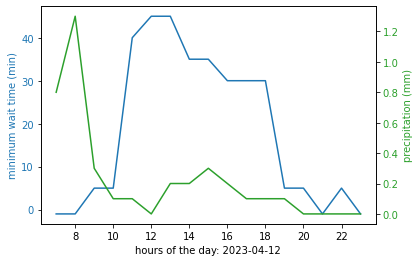

In [8]:
# plot the values on different scales 
fig = plt.figure()

# show the wait times in blue in the plot
color = 'tab:blue'
ax_waits = fig.add_subplot()
ax_waits.plot(df_joined['hours'], df_joined['wait times'], color=color)
ax_waits.set_xlabel(f'hours of the day: {rainiest_date}')
ax_waits.set_ylabel('minimum wait time (min)', color=color)
ax_waits.tick_params(axis='y', labelcolor=color)

# show the precipitation values in green in the plot
ax_prec = ax_waits.twinx()  # share the same x-axis as the first axes

color = 'tab:green'
ax_prec.plot(df_joined['hours'], df_joined['precipitation'], color=color)
ax_prec.set_ylabel('precipitation (mm)', color=color)
ax_prec.tick_params(axis='y', labelcolor=color)

plt.savefig(f'precipitation_orbitron_{rainiest_date}.pdf')
plt.show()

In [9]:
# close the HDF5 file
f.close()

## Plotting the Wait Times of the Five Rides for one Day

In [10]:
# set the font size for the following visualizations
plt.rcParams.update({'font.size': 14})

In [11]:
def get_time(timestamps_str):
    """ retrieve the time from a timestamp
    
    :param timestamps_str: the timestamp (string)
    :return: the time extracted from the timestamp (string)
    """
    return np.fromiter(map(lambda x: x[11:16], timestamps_str), '<U26')


def visualize_wait_times_day(dsets, ride_names, day, website, delay=0):
    """ create a plot showing the wait times of the five rides extracted from the website for one day
    
    :param dsets: a list containing the HDF5 datasets which store the wait times for the five rides (list of HDF5 datasets) 
    :param ride_names: the names of the five rides (list of string)
    :param day: the date (e.g., '2023-03-23') of the selected day (string)
    :param website: the website from which the wait times were extracted (string)
    :param delay: specifies the number of 5-minute intervals by which the ticklabels are to be shifted on the plot's x-axis (int) 
    """
    
    # plot the data
    fig, ax = plt.subplots(figsize=(24, 10))

    # add plots for the wait times for each ride
    counter = 0 
    for dset in dsets:
        # retrieve the storage times for the ride
        st = dset.dims[0]['storage_time']
        
        # extract the dates from the storage times
        dates = list(map(get_date, st[...]))
        
        # get the indexes of the day
        indexes = get_indexes_day(dates, day)
        
        # extract the times from the filtered storage times
        times_only = get_time(st[indexes[0]:indexes[1]].astype(str))  # make use of partial I/O
        
        # get the name of the ride
        label = ride_names[counter]
        
        # add an axes displaying the wait times
        ax.plot(times_only, dset[indexes[0]:indexes[1]], label=label)
        counter += 1

    # display ticklabels only once per hour (to make the plot's x-axis readable)
    for label in ax.xaxis.get_ticklabels():
        delay += 1
        if delay % 12 == 0: 
            continue
        else:
            label.set_visible(False)  # hide all lables that are not divisible by 12 

    plt.xlabel(f'time of day on {day}')
    plt.ylabel('wait time (min)')
    ax.legend()
    plt.savefig(f'wait_times_{website}_{day}.pdf')
    plt.show()

In [12]:
# open the HDF5 file containing the wait times and weather forecasts for Disneyland
f = h5py.File('disneyland.hdf5', 'r') 

In [13]:
# retrieve a list of the datasets storing the wait times for the five rides
def get_dset(name, group, website):
    """ retrieve a dataset from the specified HDF5 group with the specified name containing the wait times extracted from 
    the specified website
    
    :param name: the name of the ride (string)
    :param group: the HDF5 group storing the ride wait times (HDF5 group) 
    :param website: the name of the website (string)
    :return: the HDF5 dataset with the specified name from the specified website
    """
    return group[f'{name}/{website}']

# extract the HDF5 group storing the ride data
rides = f['rides']

# get a list of the ride names
names = list(rides.keys())

# retrieve a list of the datasets storing the wait times for the five rides for the respective websites
dsets_q_times = list(map(lambda x: get_dset(x, rides, 'q_times'), names))
dsets_q_park = list(map(lambda x: get_dset(x, rides, 'q_park'), names))

In [14]:
# select a day for which to plot the wait times
day = '2023-04-08'

### Queue Park

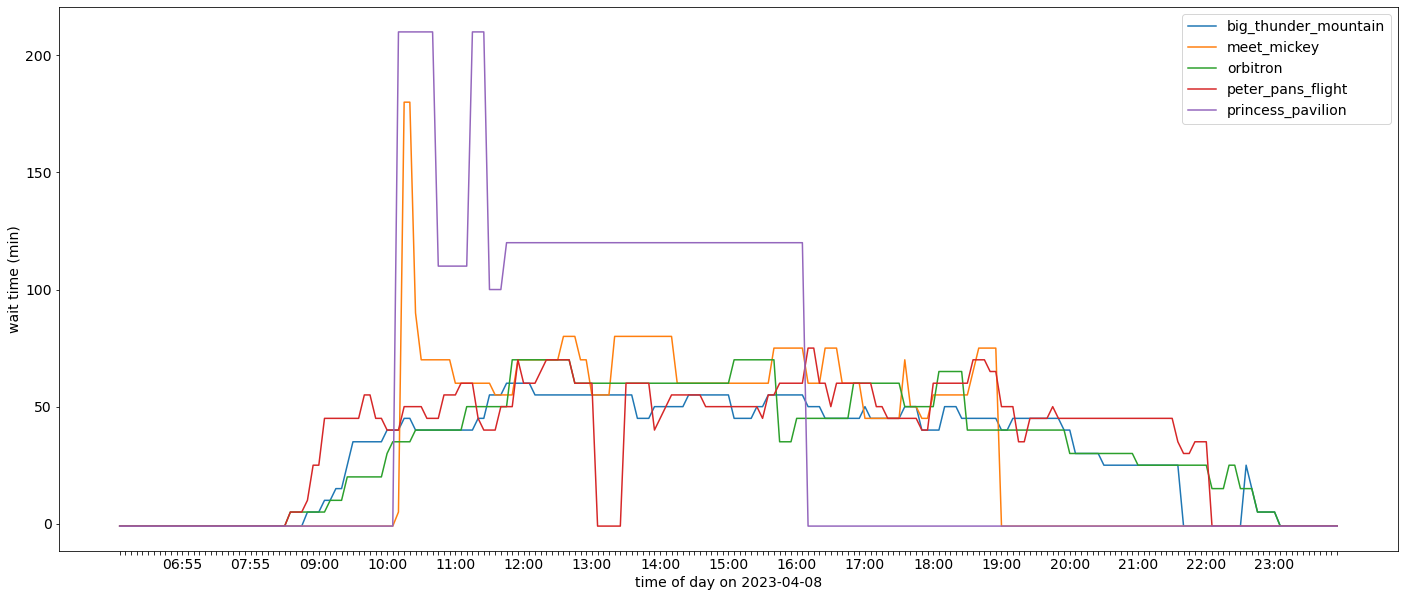

In [15]:
visualize_wait_times_day(dsets_q_park, names, day, 'q_park')

### Queue Times

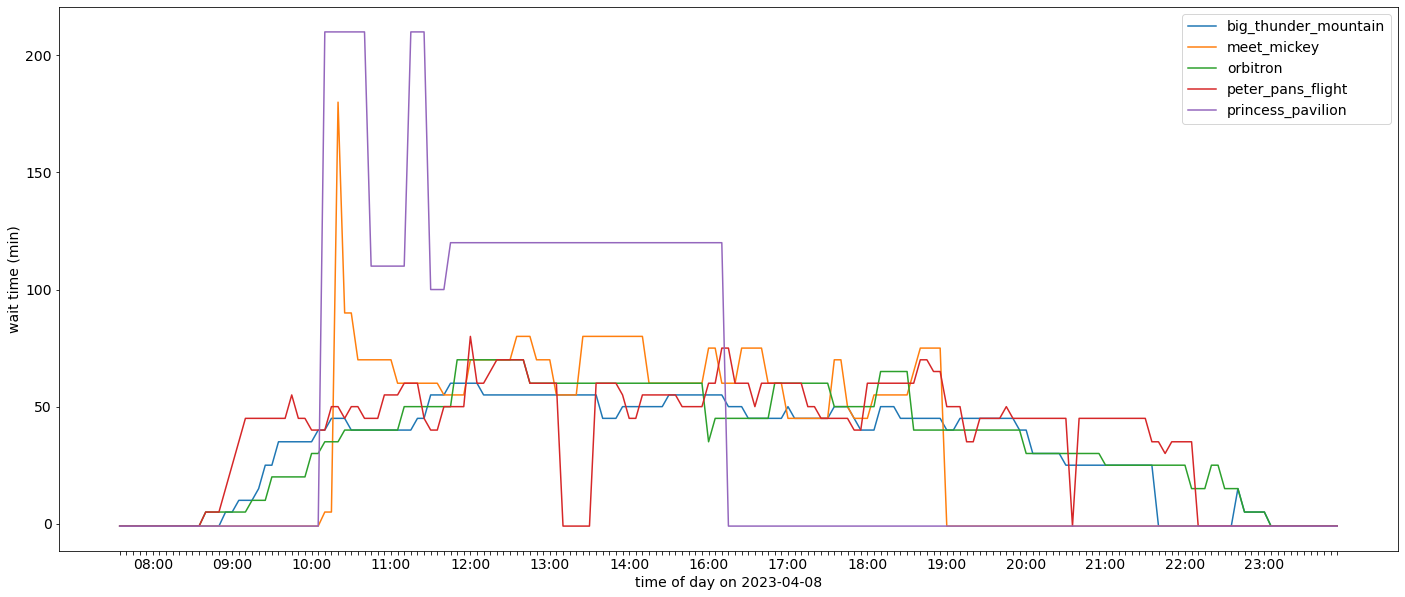

In [16]:
visualize_wait_times_day(dsets_q_times, names, day, 'q_times', delay=6)

In [17]:
# close the file
f.close()